Text(0.5, 1.05, 'Risk Measure Distribution')

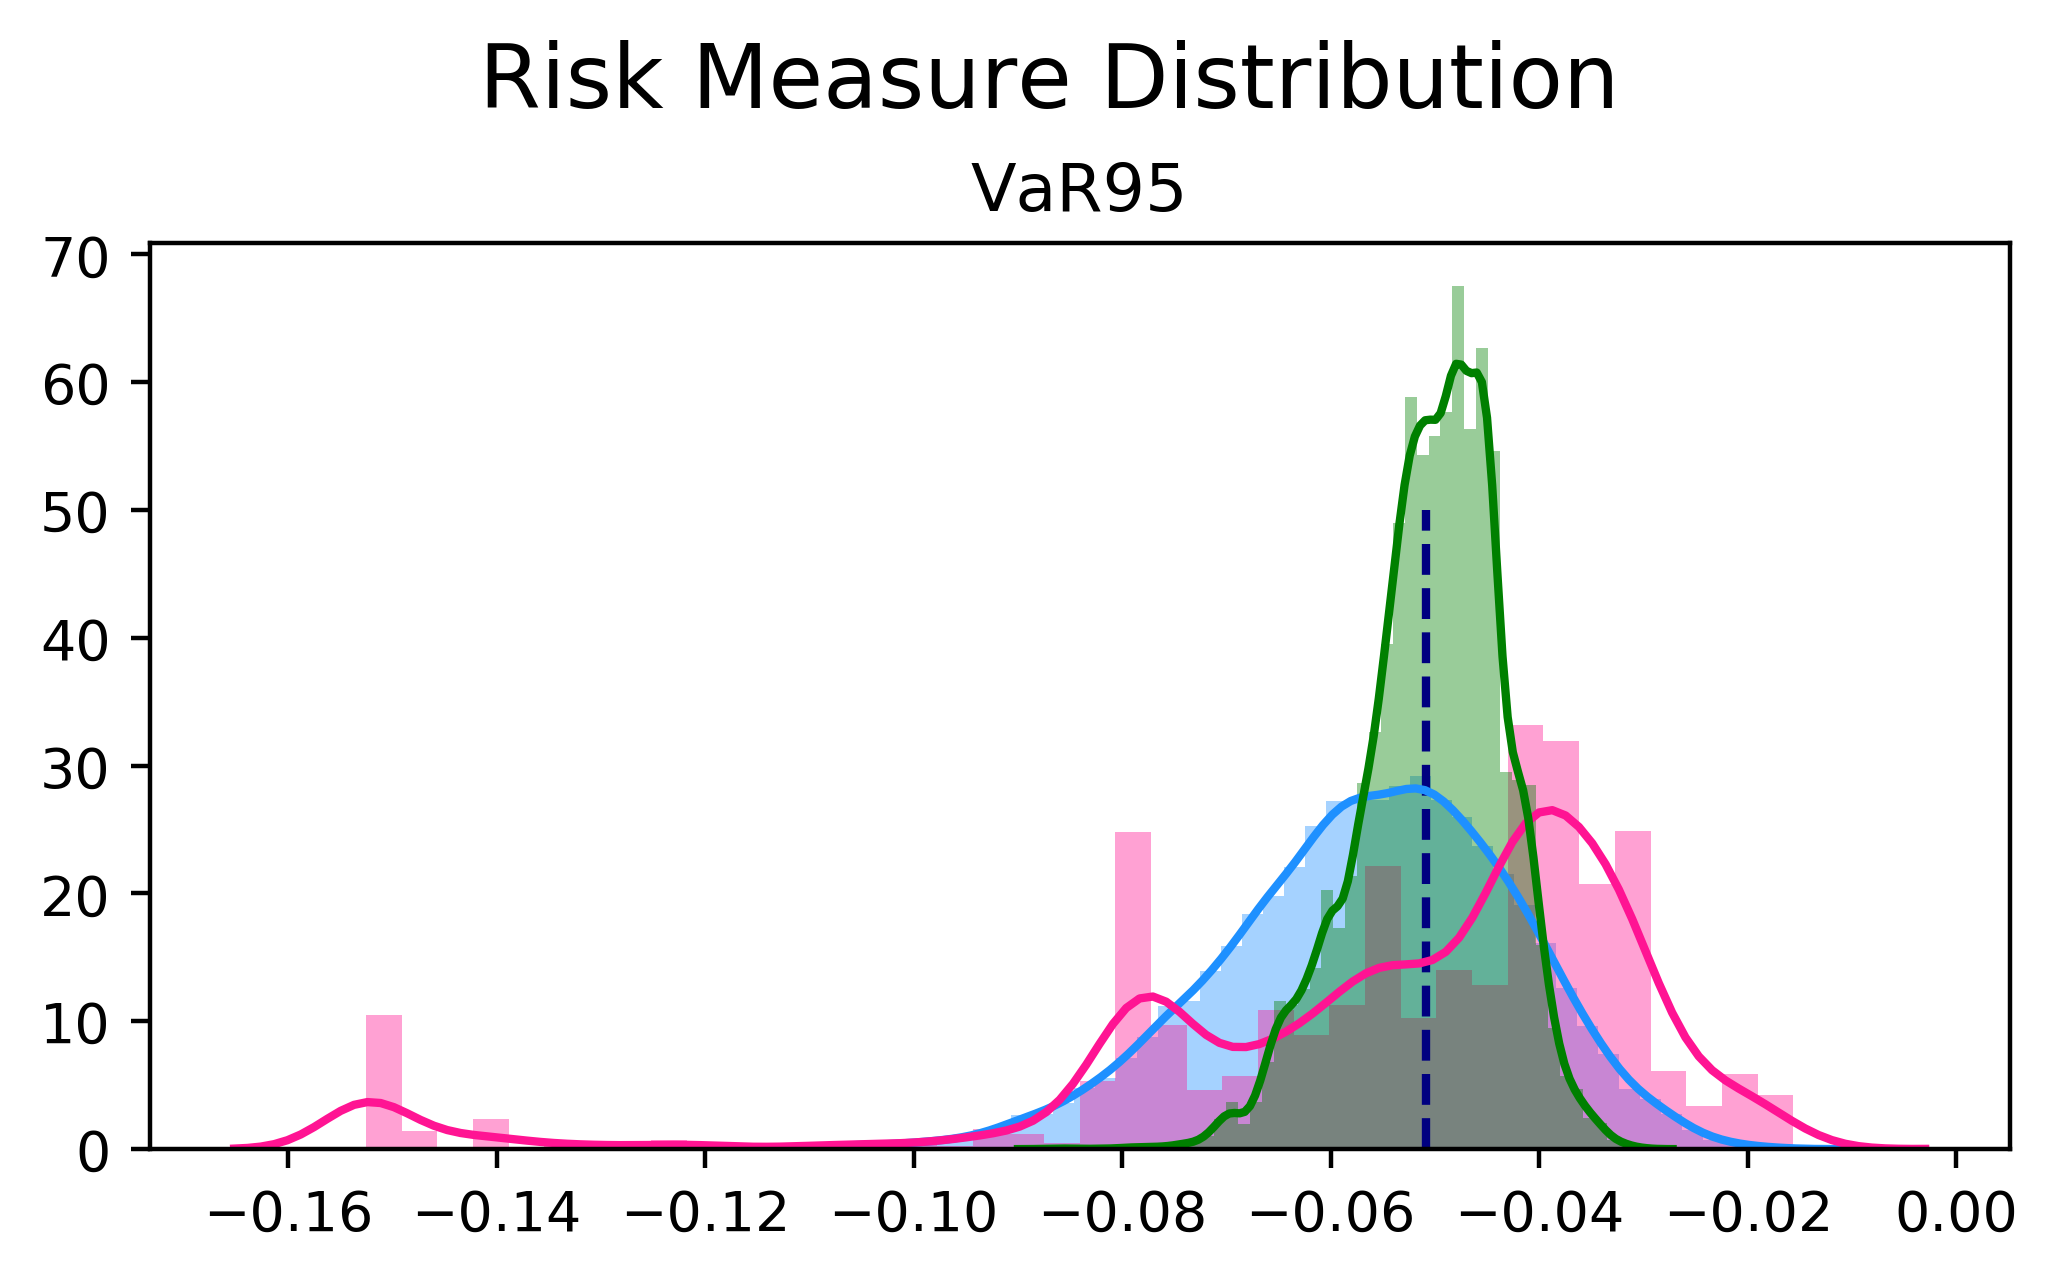

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def rolling_window(a, window):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

data = pd.read_csv("./vae_data_short.csv").iloc[:,1:]
spx = pd.read_csv("./spx.csv")

# %% 10 Day Risk Measure(daily risk number scaled up by sqrt root of 10) for each synthetic data path
vol = np.std(data,axis = 1) * np.sqrt(10)
var95 = np.percentile(data,5,axis = 1) * np.sqrt(10)
# %% Drawdown Measure for each synthetic data path
cum_ret = (1+data).cumprod(axis = 1)-1
highwatermarks = cum_ret.cummax(axis = 1) 
drawdowns = 1 - (1 + cum_ret) / (1 + highwatermarks)
drawdowns = np.max(drawdowns,axis = 1)

# %% 10 Day VaR95 calculated by 10 days rolling return
ROLLING_WINDOW = 10
data_rolling = rolling_window(data.values, ROLLING_WINDOW)
var_rolling = np.zeros(data_rolling.shape[0])
for i in range(len(data_rolling)):
    var_rolling[i]  = np.percentile(np.cumprod(1+data_rolling[i],axis = 1)[:,-1]-1,5)


# %% SPX Data
spx_ret = spx[['Close']].pct_change().dropna()

# SPX 10 Days VaR95 calculated by 10 days rolling return
rolling_ten_days_ret = ((1+spx_ret).rolling(ROLLING_WINDOW).apply(np.prod, raw=True)-1).dropna()
rolling_ten_days_var = np.percentile(rolling_ten_days_ret, 5)

# SPX 10 Days VaR95(daily risk number scaled up by sqrt root of 10). 250 Days rolling
spx_ret_rolling = rolling_window(spx_ret.values.T[0], 250)
spx_var_rolling = np.zeros(spx_ret_rolling.shape[0])
for i in range(len(spx_ret_rolling)):
    spx_var_rolling[i] = np.percentile(spx_ret_rolling[i],5)* np.sqrt(10)


# %% 10 Day VaR95 by randomly sampling historical 10 days return 

#Sampling S&P500


sampled_data = np.random.choice(rolling_ten_days_ret.values.flatten(),(20000,256))
var_dis = np.zeros(sampled_data.shape[0])
for i in range(len(var_dis)):
    var_dis[i]  = np.percentile(sampled_data[i],5)



# %%

fig, ax = plt.subplots(1, 1, figsize=(6, 3), sharey=True, dpi=400)

sns.distplot(var_rolling , color="dodgerblue",label = "Synethic Data")
sns.distplot(spx_var_rolling , color="deeppink",label = "S&P500 Data")
sns.distplot(var_dis , color="green",label = "S&P500 Sampling Data")

ax.vlines([rolling_ten_days_var], 0, 50, linestyles='dashed', colors='Navy')

ax.set_title("VaR95")

plt.suptitle('Risk Measure Distribution', y=1.05, size=16)

